In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import re
from sklearn.decomposition import PCA
from itertools import cycle
from scipy.stats import zscore
import seaborn as sns

# Read in Runs 1 & 2, align meta data

In [122]:
### Strategy is to convert exp # (i.e. 001) to sample number (1) for merging

## Run 1

### Read in Seq Data

In [2]:
data_dir = '../data/BAL/'
Run1_directories = next(os.walk(data_dir + 'Run1_reseq/'))[1]
print "{} sample directories for Run 1".format(len(Run1_directories))

2 sample directories for Run 1


#### Function to extract all data from starLog into a dictionary

In [28]:
def update_starLog_dict(star_dict, results, sid):
    if 'sample_id' not in star_dict:
        star_dict['sample_id'] = [sid]
    else:
        star_dict['sample_id'].append(sid)
    for result in results:
        try:
            category, value = result.split('|')
            category = category.strip()
            value = float(value.strip().replace('%',''))
            if category in star_dict.keys():
                star_dict[category].append(value)
            else:
                star_dict[category] = [value]
        except:
            None
    return star_dict

#### Concatenate read counts for each file

### Concat Run 1 read counts, create meta DF from starLogs

In [94]:
starLog_dict = {}

counts = pd.DataFrame()

run_dir = "/Users/tjyacoub/Dropbox/Research/Pneumonia/data/BAL/Reseq_ALL/"
meta_dir = run_dir + "meta"
counts_dir = run_dir + "counts"
os.chdir(meta_dir)

for f in glob.glob("*.out"):
    sid = f.split('Log')[0] ## SAMPLE ID
    ### Extract meta data from the starLog report - read counts etc. 
    starLog_results = open(f).readlines()
    starLog_dict = update_starLog_dict(starLog_dict, starLog_results, sid)

    
os.chdir(counts_dir)
for f in glob.glob("*.counts"):
    sid = f.split('.')[0]
    ### Extract counts for exp
    df_sid = pd.read_csv(f, sep='\t',names=[sid])
    df_sid.index.name='Gene'
    counts = pd.concat([counts, df_sid],axis=1)

    
counts_read

In [95]:
counts = counts_read.T
counts.index.name= 'sample_id'
counts = counts.ix[:,:-5]

star_meta = pd.DataFrame(starLog_dict)
star_meta.index = star_meta['sample_id']
star_meta.index.name = 'sample_id'
star_meta['Run'] = star_meta.index.map(lambda x: x.split('_')[0])
star_meta['CellType'] = star_meta.index.map(lambda x: x.split('_')[2])

In [93]:
counts.shape

(95, 58056)

In [131]:
run_dir

'/Users/tjyacoub/Dropbox/Research/Pneumonia/data/BAL/Reseq_ALL/'

In [137]:
dfc = pd.read_csv(run_dir + '../meta_data.csv', sep='\t')

In [141]:
counts.head()

Gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283695,ENSG00000283696,ENSG00000283697,ENSG00000283698,ENSG00000283699,__no_feature,__ambiguous,__too_low_aQual,__not_aligned,__alignment_not_unique
sample_id,,,,,,,,,,,,,,,,,,,,,
R1_BAL17_CD163_S1,0,0,120,0,0,1927,0,47,53,33,...,0,0,0,0,0,1346563,76682,0,0,6433351
R1_BAL25_AM_S2,6,0,74,5,31,1664,42,125,60,36,...,0,0,0,0,0,1583813,88056,0,0,9374769
R1_BAL28_CD163_S3,0,0,101,87,0,2721,92,273,194,66,...,0,0,0,0,0,2421482,146631,0,0,11344660
R1_BAL38_163_S4,0,0,366,0,0,2993,2,97,275,4,...,0,0,0,0,0,2253061,105023,0,0,10926698
R1_BAL48_AM_S5,0,0,72,18,52,2354,0,667,211,41,...,0,0,0,0,0,1253258,159282,0,0,13204646


In [143]:
star_meta['BAL'] = star_meta.index.map(lambda x: x.split('_')[1])

In [146]:
bal_dict = dict(zip(dfc['BAL'], dfc['Pneum']))

In [153]:
len(star_meta['BAL'].unique())

56

# WRITING DATA

In [191]:
dfc[dfc['Pseudomonas']==True]

,ID,BAL,CellType,Pneum,Pneum_strict,Pseudomonas,RINe,Uniquely mapped reads number,Uniquely mapped reads %
66,123_2,BAL46,AM,True,True,True,NaN,4117017,79.24
67,124_2,BAL46,163,True,True,True,NaN,5165040,78.38
68,126_2,BAL50,AM,True,True,True,NaN,5257707,71.50
88,154_2,BAL83,AM,True,True,True,NaN,3356066,65.78
89,155_2,BAL83,163,True,True,True,4.6,5117856,65.39


In [158]:
star_meta['Pneum'] = star_meta['BAL'].apply(lambda x: bal_dict[x] )
star_meta['CellType'] = star_meta['CellType'].map(lambda x: 'CD163' if '163' in x else x)

In [189]:
star_meta.to_csv('../meta_reseq.csv', sep='\t')

In [170]:
counts.to_csv("../counts_reseq.csv", sep='\t')

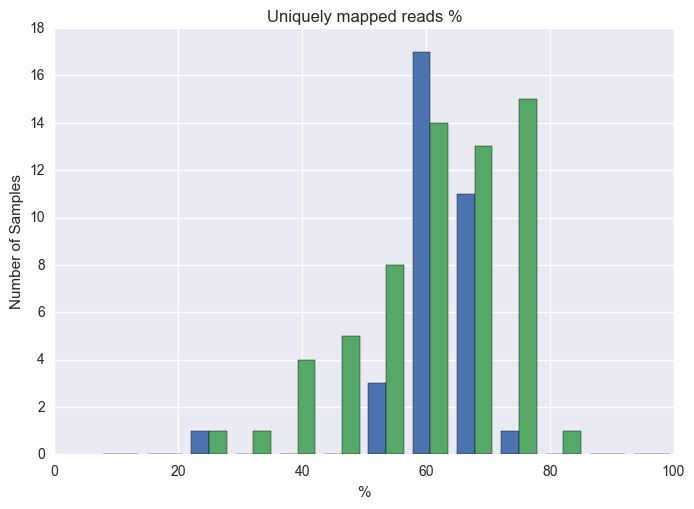

In [125]:
col = 'Uniquely mapped reads %'
uniq1 = star_meta[star_meta['Run']=='R1'][col]
uniq2 = star_meta[star_meta['Run']=='R2'][col]
plt.hist([uniq1,uniq2], bins, alpha=1)
plt.title(col)
bins = np.linspace(0, 100, 15)
#plt.hist(uniq1, bins, alpha=0.7, label='Run 1')

plt.xlabel('%')
plt.ylabel("Number of Samples")

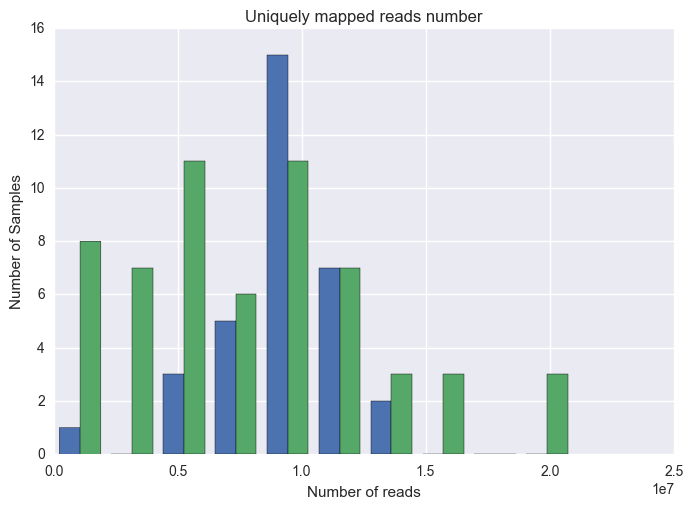

In [128]:
col = 'Uniquely mapped reads number'
uniq2df = star_meta[star_meta['Run']=='R2']
uniq2 = uniq2df[uniq2df[col] < 25e6][col]

uniq1 = star_meta[star_meta['Run']=='R1'][col]
ax1 = plt.figure()
plt.hist([uniq1,uniq2])
plt.title(col)
#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
plt.xlabel('Number of reads')
plt.ylabel("Number of Samples")

In [ ]:
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

In [99]:
np.mean(uniq1), np.std(uniq1)

(9089954.515151516, 2606096.527362879)

In [100]:
np.mean(uniq2), np.std(uniq2)

(9879390.58064516, 12541885.596961647)

In [82]:
uniq1old = pd.read_csv("../../../unique_number_run1_old.csv", 
                       sep='\t', index_col=0, header=None)

In [84]:
uniq2old = pd.read_csv("../../../unique_number_run2_old.csv", 
                       sep='\t', index_col=0, header=None)

In [101]:
uniq1old.shape, uniq1.shape

((37, 1), (33,))

In [102]:
uniq2old.shape, uniq2.shape

((62, 1), (62,))

([array([  1.,   0.,   0.,   3.,   0.,   3.,   5.,  12.,   6.,   3.]),
  array([  1.,   0.,   0.,   3.,   1.,   2.,  14.,   8.,   6.,   2.])],
 array([   150123. ,   1446997.3,   2743871.6,   4040745.9,   5337620.2,
          6634494.5,   7931368.8,   9228243.1,  10525117.4,  11821991.7,
         13118866. ]),
 <a list of 2 Lists of Patches objects>)

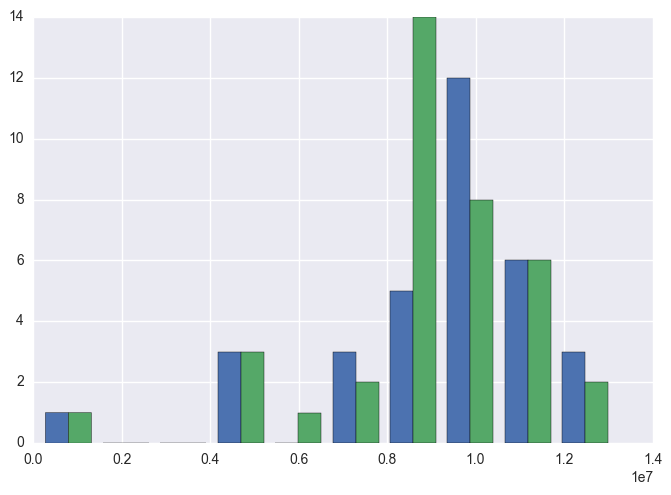

In [103]:
plt.hist([uniq1, uniq1old])

([array([ 38.,  19.,   3.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
  array([ 59.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])],
 array([  5.91800000e+03,   9.50397470e+06,   1.90020314e+07,
          2.85000881e+07,   3.79981448e+07,   4.74962015e+07,
          5.69942582e+07,   6.64923149e+07,   7.59903716e+07,
          8.54884283e+07,   9.49864850e+07]),
 <a list of 2 Lists of Patches objects>)

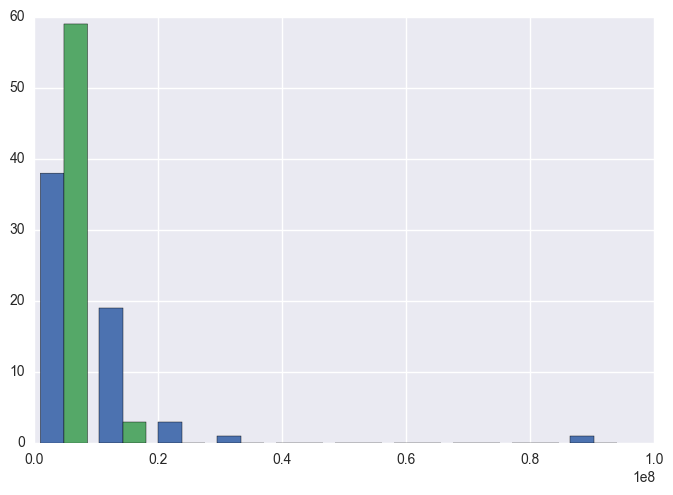

In [104]:
plt.hist([uniq2, uniq2old])

([array([  1.,   3.,  14.,  13.,   2.,   0.,   0.,   0.,   0.,   0.]),
  array([ 8.,  7.,  6.,  5.,  3.,  0.,  1.,  0.,  1.,  1.])],
 array([  5.91800000e+03,   3.23916960e+06,   6.47242120e+06,
          9.70567280e+06,   1.29389244e+07,   1.61721760e+07,
          1.94054276e+07,   2.26386792e+07,   2.58719308e+07,
          2.91051824e+07,   3.23384340e+07]),
 <a list of 2 Lists of Patches objects>)

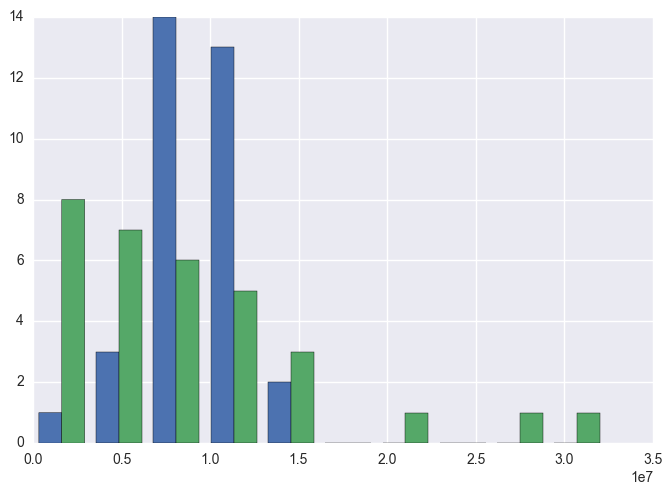

### Create meta df for experimental data to map Sample # -> BAL

In [6]:
exp_meta = pd.read_csv(data_dir + 'Run1_Index_BAL_RIN.csv')
exp_meta['CellType'] = exp_meta['Library Name'].map(lambda x: x.split('_')[1])
exp_meta['CellType'] = exp_meta['CellType'].map(lambda x: x[-3:])
exp_meta['BAL'] = exp_meta['Library Name'].map(lambda x: x.split('_')[0])
exp_meta['BAL'] = exp_meta['BAL'].map(lambda x: 'BAL' + x[-2:])  ### Fix BA81
exp_meta.index = exp_meta['Sample Number']

## Merge concatenated data with BAL 
run1_counts_star_exp = pd.merge(run1_counts_star, exp_meta, how='inner', left_on='Sample Number', right_on='Sample Number')
run1_counts_star_exp['Run'] = 1

In [7]:
## BALs not in exp
#samples_not_in_exp = list(set(run1_cts_star['Sample Number'].values) - set(exp_meta['Sample Number'].values))
#samples_not_in_exp
#run1_cts_star[run1_cts_star['Sample Number'].isin(samples_not_in_exp)]['BAL'];

In [178]:
all_data = pd.concat([run1_counts_star_exp, run2_counts_star_exp])
### 125_2 is the spike ERCC
try: all_data.drop('125_2', inplace=True)
except: print 'x'

In [179]:
all_data.shape

(95, 60240)

In [59]:
all_data['ID'] = all_data.apply(lambda x: str(x['Original Sample Number']) + '_' + str(x['Run']), axis=1)
all_data.index = all_data['ID']

In [16]:
### Split data into gene and meta

In [62]:
gene_cols = [col for col in all_data.columns if 'ENSG' in col or 'ERCC' in col] 
meta_cols = [col for col in all_data.columns if col not in gene_cols]


In [164]:
counts_data = all_data[gene_cols]

In [165]:
meta_data = all_data[meta_cols]

# Load in EDW data

In [133]:
data_dir

'../data/BAL/'

In [132]:
dfclinic = pd.read_csv(data_dir + "ICU_BAL_update.csv")
dfclinic['BAL'] = dfclinic['BAL NUM'].map(lambda x: 'BAL' + str(x))
dfclinic['Pneum'] = dfclinic['Pneumonia (10^3 CFU + 50% neuts)'].map(lambda x: 'Y' in x)
dfclinic['Pneum_strict'] = dfclinic['Pneumonia (10^4 CFU + 80% neuts)'].map(lambda x: 'Y' in x)
#dfclinic.index = dfclinic['BAL']
#BAL_Pneum_dict = dict(zip(dfclinic['BAL'], dfclinic['Pneum']))
#BAL_Pneum_dicts = {'Lenient': dict(zip(dfclinic['BAL'],dfclinic['Pneum'])),
#                   'Strict': dict(zip(dfclinic['BAL'],dfclinic['Pneum_strict']))}
dfclinic['Pseudomonas'] = dfclinic['Pneumonia pathogen'].map(lambda x: 
                                        'seudomonas' in x if pd.notnull(x) else False )

IOError: File ../data/BAL/ICU_BAL_update.csv does not exist

In [76]:
clinical_data = dfclinic.rename(columns={'Age ': 'Age', 'Gender ': 'Gender', 'Race ':'Race',
                        'Ethnicity': 'Ethnicity', '% Monocytes': '%Monocytes'})

In [166]:
all_meta_data = pd.merge(meta_data, clinical_data, left_on='BAL', right_on='BAL', how='inner', left_index='X')
all_meta_data.index = all_meta_data.apply(lambda x: str(x['Original Sample Number']) + '_' + str(x['Run']), axis=1)
all_meta_data = all_meta_data[['BAL', 'CellType', 'Pneum','Pneum_strict','Pseudomonas', 'RINe',
                               'Uniquely mapped reads number','Uniquely mapped reads %']]
all_meta_data.index.name = 'ID'

### Write counts

In [167]:
counts_data.to_csv(data_dir + "counts_data.csv",sep='\t')


### Write meta (starLog (seq stats), clinical + library prep)

In [168]:
all_meta_data.to_csv(data_dir + "meta_data.csv", sep='\t')

###  Check distribution of celltype

In [43]:
all_data['CellType'].value_counts()

AM     49
163    46
Name: CellType, dtype: int64

###  Get data with pneum positive

In [492]:
#pos_meta = meta_data[meta_data['BAL'].isin(pos_bals)]
#neg_meta = meta_data[~meta_data['BAL'].isin(pos_bals)]


In [45]:
#new_bals = meta_data['BAL'].unique()
#clin_data = dfclinic[dfclinic['BAL'].isin(new_bals)]
pos_bals = dfc[dfc['Pneum']==True]['BAL'].values
neg_bals = dfc[dfc['Pneum']==False]['BAL'].values

In [46]:
import numpy as np
from scipy.stats.stats import zscore

In [62]:
p = pd.merge(clin_data, meta_data, left_on='BAL', right_on='BAL', how='outer')

In [72]:
clin_data = clin_data.rename(columns={'APS Total Score':'APS'})
dfc = pd.merge(clin_data, meta_data, left_on='BAL', right_on='BAL', how='outer')
dfc['ID'] = dfc.apply(lambda x: str(x['Original Sample Number']) + '_' + str(x['Run']), axis=1)
dfc.index = dfc['ID']
dfpos = dfc[dfc['Pneum']==True]
dfneg = dfc[dfc['Pneum']==False]
#dfp = dfc[dfc['Pneum']==True]['BAL'].unique()


In [117]:
def match_score(x, zAPS, zAge):
    return np.sqrt((x['zAPS'] - zAPS)**2 + (x['zAge'] - zAge)**2)
def match_score_noz(x, APS, Age):
    return np.sqrt((x['APS'] - APS)**2 + (x['Age'] - Age)**2)

## Patient matching
Originally intended for choosing samples to resequence.
Can now be used to select negative samples to include in model.
(There are fewer pos. than neg. samples, and we want equal numbers of each)
Matching is used to reduce confounding factors like age and general physical wellness.

INPUT: columns to match on i.e. Age, APS Score

In [118]:

#dfp = pos_data
match_dict = {}

dfpos = dfc[dfc['Pneum']==True]
dfneg = dfc[dfc['Pneum']==False]

min_map_percent = 50
min_map_number = 400000
dfneg = dfneg[dfneg['Uniquely mapped reads %'] > min_map_percent]
dfneg = dfneg[dfneg['Uniquely mapped reads number'] > min_map_number]
neg_samples_left = list(dfneg.index.values)

dfp = dfpos # to print

print dfpos.shape
for i, row in dfpos.iterrows():
    pid = row['ID']
    gender = row['Gender']
    celltype = row['CellType']
    #RINe = row['RINe']
    #zAPS = row['zAPS']
    #zAge = row['zAge']
    
    ### Create dataframe for potential negative Matches (dfm = dfmatches)
    #print neg_samples_left
    dfm = dfneg.ix[neg_samples_left]
    dfm = dfm[dfm['Gender'] == gender]
    dfm = dfm[dfm['CellType'] == celltype]
    
    ### Calculate metric for matching distance
    #dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, row['APS'], row['Age']), axis=1)
    dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, row['APS'], 
                                            row['Age']), axis=1)

    #dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, zAPS, zAge), axis=1)

    min_score = np.min(dfm['Match score'])
    min_data = dfm[dfm['Match score'] == min_score]
    match_id = min_data['ID'].values[0]
    match_dict[pid] = match_id
    #print match_id
    
#    print match_data.head()
    neg_samples_left.remove(str(match_id))

### After matching, get a handful of other negative samples in case there are problems in prep

dfp['Match ID'] = dfp['ID'].map(lambda x: match_dict[x])
dfp['Match Celltype'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'CellType'])
dfp['Match APS'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'APS'])
dfp['Match Age'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Age'])
dfp['Match Pneum'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Pneum'])
dfp['Match BAL'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'BAL'])
dfp['% Uniq. Map.'] = dfp['ID'].apply(lambda x: dfc.loc[x, 'Uniquely mapped reads %'])
dfp['RIN'] = dfp['ID'].apply(lambda x: dfc.loc[x, 'RINe'])
dfp['Match RIN'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'RINe'])
dfp['Match % Uniq. Map.'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Uniquely mapped reads %'])
df = dfp[['ID', 'Match ID', 'Age', 'Match Age', 'BAL', 'Match BAL', 
          'APS', 'Match APS', 'CellType', 'Match Celltype', 'Pneum', 'Match Pneum',
         '% Uniq. Map.', 'Match % Uniq. Map.', 'RIN', 'Match RIN']]

(33, 103)


In [118]:


#dfp = pos_data
match_dict = {}

dfpos = dfc[dfc['Pneum']==True]
dfneg = dfc[dfc['Pneum']==False]

min_map_percent = 50
min_map_number = 400000
dfneg = dfneg[dfneg['Uniquely mapped reads %'] > min_map_percent]
dfneg = dfneg[dfneg['Uniquely mapped reads number'] > min_map_number]
neg_samples_left = list(dfneg.index.values)

dfp = dfpos # to print

print dfpos.shape
for i, row in dfpos.iterrows():
    pid = row['ID']
    gender = row['Gender']
    celltype = row['CellType']
    #RINe = row['RINe']
    #zAPS = row['zAPS']
    #zAge = row['zAge']
    
    ### Create dataframe for potential negative Matches (dfm = dfmatches)
    #print neg_samples_left
    dfm = dfneg.ix[neg_samples_left]
    dfm = dfm[dfm['Gender'] == gender]
    dfm = dfm[dfm['CellType'] == celltype]
    
    ### Calculate metric for matching distance
    #dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, row['APS'], row['Age']), axis=1)
    dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, row['APS'], 
                                            row['Age']), axis=1)

    #dfm['Match score'] = dfm.apply(lambda x: match_score_noz(x, zAPS, zAge), axis=1)

    min_score = np.min(dfm['Match score'])
    min_data = dfm[dfm['Match score'] == min_score]
    match_id = min_data['ID'].values[0]
    match_dict[pid] = match_id
    #print match_id
    
#    print match_data.head()
    neg_samples_left.remove(str(match_id))

### After matching, get a handful of other negative samples in case there are problems in prep

dfp['Match ID'] = dfp['ID'].map(lambda x: match_dict[x])
dfp['Match Celltype'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'CellType'])
dfp['Match APS'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'APS'])
dfp['Match Age'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Age'])
dfp['Match Pneum'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Pneum'])
dfp['Match BAL'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'BAL'])
dfp['% Uniq. Map.'] = dfp['ID'].apply(lambda x: dfc.loc[x, 'Uniquely mapped reads %'])
dfp['RIN'] = dfp['ID'].apply(lambda x: dfc.loc[x, 'RINe'])
dfp['Match RIN'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'RINe'])
dfp['Match % Uniq. Map.'] = dfp['Match ID'].apply(lambda x: dfc.loc[x, 'Uniquely mapped reads %'])
df = dfp[['ID', 'Match ID', 'Age', 'Match Age', 'BAL', 'Match BAL', 
          'APS', 'Match APS', 'CellType', 'Match Celltype', 'Pneum', 'Match Pneum',
         '% Uniq. Map.', 'Match % Uniq. Map.', 'RIN', 'Match RIN']]

(33, 103)


In [104]:
df.to_csv('Resequence_IDs.csv')

In [149]:
print np.mean(abs(df['Age'] - df['Match Age']))
print np.mean(abs(df['APS'] - df['Match APS']))
df;

7.27272727273
12.3333333333


In [152]:
reseq = list(df['ID'].values) + list(df['Match ID'].values)

In [915]:
print "AGE only, no ZSCORE"
print np.mean(abs(df['Age'] - df['Match Age']))
print np.mean(abs(df['APS'] - df['Match APS']))
df.head(10)

AGE only, no ZSCORE
2.86666666667
31.8333333333


,ID,Match ID,Age,Match Age,BAL,Match BAL,APS,Match APS,CellType,Match Celltype,Pneum,Match Pneum,Gender,Match Gender
ID,,,,,,,,,,,,,,
003_1,003_1,138_2,62,61,BAL28,BAL62,65,57,163,163,True,False,Male,Male
110_2,110_2,137_2,62,61,BAL28,BAL62,65,57,AM,AM,True,False,Male,Male
111_2,111_2,019_1,58,59,BAL33,BAL81,101,47,AM,AM,True,False,Male,Male
112_2,112_2,020_1,58,59,BAL33,BAL81,101,47,163,163,True,False,Male,Male
004_1,004_1,017_1,58,55,BAL38,BAL77,90,108,163,163,True,False,Male,Male
116_2,116_2,150_2,58,55,BAL38,BAL77,90,108,AM,AM,True,False,Male,Male
122_2,122_2,014_1,30,22,BAL45,BAL71,43,60,AM,AM,True,False,Female,Female
123_2,123_2,102_2,61,59,BAL46,BAL15,65,69,AM,AM,True,False,Female,Female
124_2,124_2,153_2,61,63,BAL46,BAL82,65,50,163,163,True,False,Female,Female


In [830]:
len(match_dict.values()) - len(set(match_dict.values()))

0

# Proceeding to normalization, filtering

## Filter by a minimum number of unique reads

#### Create normalization factor based on unique reads

In [181]:
min_uniques = 4e6
min_gene_count = 10 ## All genes from all samples must have 10 counts
## AM
def filter_norm(df, meta, min_gene_count=min_gene_count, min_uniques=min_uniques):
    bal_dict = dict(zip(meta.index,meta['Norm_Factor']))
    samples_min_unique = meta[meta['Uniquely mapped reads number'] > min_uniques].index
    df = df.ix[samples_min_unique].T
    for i in df.columns:
        norm_fac = meta.loc[i,'Norm_Factor']
        df[i] = df[i].map(lambda x: float(x)/norm_fac)
    df = df.T
    df = df.loc[:, df.min(axis=0) > min_gene_count]
    df = df.apply(lambda x: np.log2(x + 1))
    return df

In [182]:
counts_data_min_gene_10 = filter_norm(counts, star_meta, min_gene_count=10, min_uniques=0)

In [185]:
counts.shape

(95, 58051)

In [184]:
counts_data_min_gene_10.shape

(95, 111)

In [159]:
counts_data_min_gene_10.to_csv(data_dir + 'counts_min_gene_10.csv', sep='\t')

In [ ]:
#df_AM_all.to_csv(data_dir + 'df_AM_all.csv','\t')
#df_163_all.to_csv(data_dir + 'df_163_all.csv','\t')